<a href="https://colab.research.google.com/github/yc386/anubis_palaeoproteomics/blob/main/Anubis_scripts_for_figs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# requirments

In [ ]:
import importlib
import subprocess
import sys

required_packages = {
    "pandas": "pd",
    "regex": "re",
    "numpy": "np",
    "altair": "alt",
    "matplotlib": "plt",
    "altair_saver": "save",
    "scikit-learn": "sklearn"
}

def install_if_missing(pip_name, import_name=None):
    try:
        importlib.import_module(import_name or pip_name)
    except ImportError:
        print(f"Installing missing package: {pip_name}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

for pip_name in required_packages:
    import_name = pip_name if pip_name != "scikit-learn" else "sklearn"
    install_if_missing(pip_name, import_name)

import pandas as pd
import regex as re
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from altair_saver import save

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, train_test_split,
    cross_val_score, KFold, StratifiedKFold
)
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score, recall_score,
    roc_curve, auc, classification_report, ConfusionMatrixDisplay,
    f1_score, roc_auc_score
)


Installing missing package: altair_saver


# Fig 1

In [ ]:
#Fig 1a

def confusion_matrix_plot(y_test, y_pred, save_path):

    """
    Plot and save a normalised confusion matrix as percentages. y_test and y_pred are from sklearn.metrics

    Args:
        y_test (array-like): Ground truth (correct) labels.
        y_pred (array-like): Predicted labels by the model.
        save_path (str): File path to save.
    """

    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_normalized = np.round(cm_normalized, 2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
    fig, ax = plt.subplots()
    disp.plot(cmap='Blues', ax=ax, values_format='.2f')

    ax.text(0, 0.12, 'True Negative (%)', ha='center', va='bottom',
            fontsize=10, color='white', weight='bold')
    ax.text(1, 0.12, 'False Positive (%)', ha='center', va='bottom',
            fontsize=10, color='blue', weight='bold')
    ax.text(0, 1.12, 'False Negative (%)', ha='center', va='bottom',
            fontsize=10, color='blue', weight='bold')
    ax.text(1, 1.12, 'True Positive (%)', ha='center', va='bottom',
            fontsize=10, color='white', weight='bold')

    plt.savefig(save_path, dpi=500, bbox_inches='tight')
    plt.show()

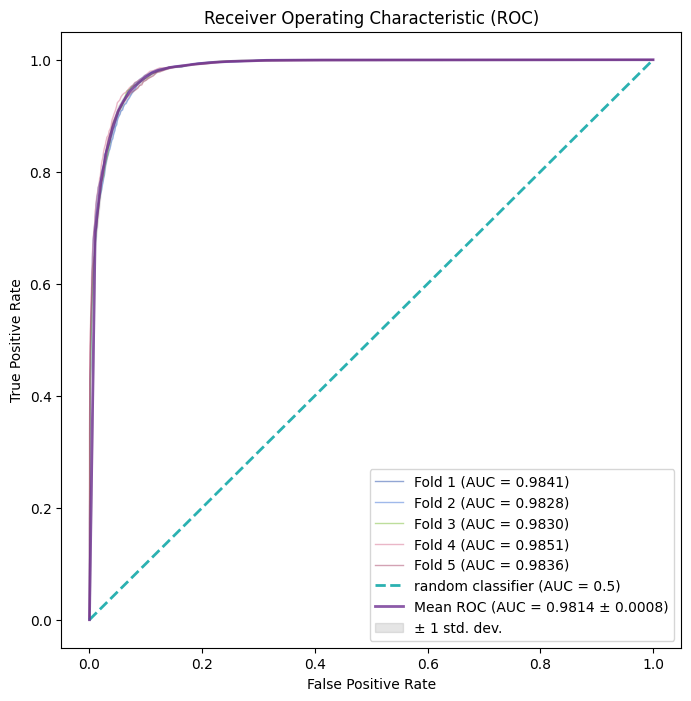

In [ ]:
#Fig 1b

# Load data
df = pd.read_csv("anubis_style.csv")  # <-- Replace with an actual file path, check the sample csv for essential columns

# Define features and target
X = df[
    ['Phi', 'Psi', 'SASA', 'CG_N_Distance', 'IUPRED', 'Robinson_half',
     'int_ratio', 'adjusted_pI', 'FDR_adjusted', 'tryp_ratio',
     'delta_rt_model', 'matched_intensity_pct', 'precursor_ppm']
]
y = df['modified_class']

colors = ['#274fab', '#4374d7', '#7cbf3b', '#d77091', '#a94769']

# Initialise the model and CV
model = RandomForestClassifier() # <-- parameter can be changed or call a pretrained model via pickle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Collect stats for the five-fold CV
fprs, tprs, aucs = [], [], []
for train_idx, test_idx in cv.split(X, y):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_score = model.predict_proba(X.iloc[test_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y.iloc[test_idx], y_score)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc(fpr, tpr))


def plot_roc(fprs, tprs, aucs, save_path="roc_curve.png"): # <-- save path can be changed

    """Plot mean ROC curve with individual test folds and ±1 std shading."""

    mean_fpr = np.linspace(0, 1, 100)

    interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
    for tpr in interp_tprs:
        tpr[0] = 0.0

    mean_tpr = np.mean(interp_tprs, axis=0)
    std_tpr = np.std(interp_tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.figure(figsize=(8, 8))
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        plt.plot(fpr, tpr, lw=1, alpha=0.5, color=colors[i % len(colors)],
                 label=f'Fold {i+1} (AUC = {aucs[i]:.4f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='#2bb1b1',
             lw=2, label='random classifier (AUC = 0.5)')
    plt.plot(mean_fpr, mean_tpr, color='#6f3192', lw=2, alpha=.8,
             label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr,
                     color='grey', alpha=0.2, label='± 1 std. dev.')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.savefig(save_path, dpi=500, bbox_inches='tight')
    plt.show()


# Plot ROC curve
plot_roc(fprs, tprs, aucs)

# Fig 2

In [ ]:
#Fig 2 & Supplementary Fig 2
#key difference --> Fig2: polyfit from numpy vs Sup Fig2: linregress from scipy.stats

df = pd.read_csv("your_file.csv")  # <-- replace with actual path
# Time point order and BLG type colors
time_point_order = [0, 3, 6, 9, 12]
domain = ['BLG_only', 'C8', 'C8+sugar', 'sugar']
range_ = ['#4097d9', '#7d67e0', '#e8853a', '#2bb27c']

# Output path for the HTML format
save_path = "line_plot.html"  # <-- replace with actual path


def line_point_plot(df, time_point_order, domain, range_, save_path):

    """
    Create and save an Altair line+scatter plot of deamidation abundance over time.

    Args:
        df (pd.DataFrame): DataFrame with 'integer_time_point', 'y_pred',
                           'de_abundance', 'BLG_type', and 'pattern_position'.
        time_point_order (list): Order to sort time points on the X-axis.
        domain (list): Unique BLG types to map to colours.
        range_ (list): Corresponding colors for each BLG type.
        save_path (str): File path to save.
    """

    line = alt.Chart(df).mark_line().encode(
        alt.X('integer_time_point:O', sort=time_point_order),
        alt.Y('y_pred:Q'),
        alt.Color('BLG_type:N', scale=alt.Scale(domain=domain, range=range_))
    ).properties(width=200, height=200)

    points = alt.Chart(df).mark_circle().encode(
        alt.X('integer_time_point:O', sort=time_point_order, title='Time (hours)'),
        alt.Y('de_abundance:Q', title='Deamidation Abundance'),
        alt.Color('BLG_type:N', scale=alt.Scale(domain=domain, range=range_))
    )

    plot = alt.layer(points, line).facet(
        facet=alt.Facet('pattern_position:N', title=''),
        columns=3
    )

    plot.save(save_path)


# Fig 3

In [ ]:
#Fig 3a

df = pd.read_csv("data.csv")  # <-- replace with actual file path

save_path = "bar_plot.html"  # <-- replace with actual save path

# Define custom pattern sort order (optional)
pattern_order = [
    'IQ[29]K', 'AQ[51]S', 'LQ[75]K', 'EN[79]G', 'AQ[84]K', 'LN[104]E',
    'EN[106]K', 'EN[125]S', 'EQ[131]S', 'CQ[136]C',
    'FN[168]P', 'TQ[171]L', 'EQ[175]C'
]


def plot_bar(df, pattern_order, save_path):

    """
    Create and save a faceted bar plot of deamidation abundance by pattern and sample.

    Args:
        df (pd.DataFrame): Input dataframe with columns:
                           'modified_class', 'pattern_position', 'de_abundance', 'sample'.
        pattern_order (list): Ordered list of pattern_position values to sort y-axis.
        save_path (str): File path to save.
    """

    bar = alt.Chart(df).mark_bar().encode(
        alt.X('modified_class:O', axis=alt.Axis(labelAngle=0)),
        alt.Y('pattern_position:O', sort=pattern_order),
        alt.Color('de_abundance:Q',
                  scale=alt.Scale(scheme='lighttealblue'),
                  title='Deamidation Abundance',
                  legend=alt.Legend(orient="right"))
    ).properties(
        width=150,
        height=300
    )

    final_bar = alt.layer(bar).facet(
        column=alt.Column('sample:N', title='')
    )

    final_bar.save(save_path)


In [ ]:
#Fig 3b

df = pd.read_csv("data.csv")  # <-- replace with actual file path

save_path = "heatmap_plot.html"  # <-- replace with actual save path

sample_palette = {
    'Jeong_2018': '#e35100',
    'Wilkin_2020': '#935ff4',
    'Wilkin_2021': '#d09a00'
    }


def plot_heatmap(df, sample_palette, save_path):
    """
    Create and save a heatmap of log10_N vs. log10_Q values with sample-specific color overlay,
    density shading, and median reference lines.

    Args:
        df (pd.DataFrame): Must include columns 'log10_N', 'log10_Q', and 'sample'.
        save_path (str): File path to save.
    """

    midpoint_N2D = df['log10_N'].median()
    midpoint_Q2E = df['log10_Q'].median()
    x_min=0
    x_max=5

    heatmap = alt.Chart(df).mark_rect().encode(
    alt.X('log10_N:Q', bin=alt.Bin(extent=[x_min, x_max])),
    alt.Y('log10_Q:Q', bin=True),
    alt.Color('count()', scale=alt.Scale(scheme='greenblue'), legend=alt.Legend(orient="bottom"),
              title='Raw file count'))

    points = alt.Chart(df).transform_calculate(
    jitter_x='datum.log10_N + (random() + 0.025) * 0.125',
    jitter_y='datum.log10_Q + (random() - 0.025) * 0.125'
    ).mark_circle(
    size=100,
    ).encode(
    alt.X('jitter_x:Q', title='N2D abundance per raw'),
    alt.Y('jitter_y:Q', title='Q2E abundance per raw'),
    alt.Color('sample:N', scale=alt.Scale(domain=list(sample_palette.keys()), range=list(sample_palette.values())),
              legend=alt.Legend(orient='bottom'))
    ).properties(width=450, height=450)

    vline = alt.Chart().mark_rule(color='#000d4f', strokeDash=[8,8], strokeWidth=2).encode(
    x=alt.datum(midpoint_N2D))

    hline = alt.Chart().mark_rule(color='#71797E', strokeDash=[8,8], strokeWidth=2).encode(
    y=alt.datum(midpoint_Q2E))

    both_high = alt.Chart(pd.DataFrame({'x': [6], 'y': [3.14]})).mark_text(
    text='Q2E median',
    align='right',
    fontWeight='bold',
    fontSize=11,
    color='#71797E').encode(x='x:Q', y='y:Q')

    high_N2D = alt.Chart(pd.DataFrame({'x': [3.96], 'y': [4.9]})).mark_text(
    text='N2D median',
    align='right',
    fontWeight='bold',
    fontSize=11,
    color='#000d4f').encode(x='x:Q', y='y:Q')

    combined=heatmap + points + vline + hline + both_high + high_N2D

    combined.save(save_path)


In [ ]:
# Fig 3c

df = pd.read_csv("data.csv")  # <-- replace with actual file path

save_path = "comparative_bar.html"  # <-- replace with actual save path

protein_colour_palette = {
    'P02754': '#1b99c5',
    'P00761': '#d453de'}

def plot_comparative_bar(df, protein_colour_palette, save_path):

    """
    Create and save a faceted comparative bar plot of protein modification intensity
    with error bars across samples.

    Args:
        df (pd.DataFrame): Must contain 'protein_type', 'weighted_mod_int', and 'sample' columns.
        save_path (str): Path to save.
    """

    protein_color_palette = {
    'P02754': '#1b99c5',
    'P00761': '#d453de'}

    bars= alt.Chart(df).mark_bar().encode(
    x=alt.X('protein_type:N', title=''),
    y=alt.Y('weighted_mod_int:Q', aggregate='mean'),
    color=alt.Color('protein_type:N', title='Protein Type', scale=alt.Scale(domain=list(protein_colour_palette.keys()),
                                                                            range=list(protein_colour_palette.values()))))

    error_bars = alt.Chart(df).mark_errorbar(extent='ci').encode(
    x=alt.X('protein_type:N', title=''),
    y=alt.Y('weighted_mod_int:Q', aggregate='mean', title='Mean total modification intensity'))

    final=alt.layer(bars, error_bars, data=df).facet(
    column=alt.Column('sample:N', title='Sites'))

    final.save(save_path)


# Supplementary Figs

In [ ]:
#Supplementary Fig 1

df = pd.read_csv("data.csv")  # <-- replace with actual file path

save_path = "gini_importance.html"  # <-- replace with actual save path

feature_list=df['Feature'].tolist()

colour_palette = {
    'MS2-based': '#59bdff',
    'physico-chemical': '#af8cff'
    }

def plot_gini_importance(df, colour_palette, feature_list, save_path):

    """
    Create and save a horizontal bar plot showing Gini feature importance.

    Args:
        df (pd.DataFrame): DataFrame with columns 'Feature', 'Gini Importance', and 'feature_type'.
        feature_list (list): List of features in desired y-axis order.
        save_path (str): File path to save.
    """

    bars= alt.Chart(df).mark_bar().encode(
    x=alt.X('Gini Importance:Q'),
    y=alt.Y('Feature:N', sort=feature_list),
    color=alt.Color('feature_type:N', title='Feature Type',
                    scale=alt.Scale(domain=list(colour_palette.keys()), range=list(colour_palette.values())),
                    legend=alt.Legend(orient='bottom-right')))

    bars.save(save_path)